In [ ]:
# Importing libraries
try:
  import pennylane as qml
except:
  !pip install pennylane --q
  import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 36.8 MB/s eta 0:00:00


In [ ]:
# Data encoding and layer
np.random.seed(42)

dev = qml.device('default.qubit', wires=1)

def S(x: float):
    """.
    x: input data
    Returns: Adds a RX gate with x as the phase
    """
    qml.RX(x, wires=0)

def W(theta: list):
    """
    theta: rotation angles
    Returns: Adds a rotation gate with theta as the angles
    """
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

# Set up the QNode
@qml.qnode(dev)
def serial_quantum_model(weights: NDArray,
                         x: float):
    """
    weights: rotation angles
    x: input data
    Returns: Applied the Rotation and RX gate layer
             and returns the expectation value
    """
    # Repeating layers based on the initial weight shape
    S(x)
    W(weights[0])
    for theta in weights[1:-1]:
        # Rotation layer
        W(theta)
        # Data encoding
        S(x)

    # last rotation layer
    W(weights[-1])

    # Return the Pauli Z expectation value
    return qml.expval(qml.PauliZ(wires=0))

In [ ]:
def cost(weights: NDArray,
         x: list,
         y: list):
    """
    weights: rotation angles
    x: input data
    y: target data
    Returns: cost function with square loss
    """

    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y,predictions)

def square_loss(targets: list,
                predictions: list):
    """
    targets: target data
    predictions: predicted data
    Returns: square loss
    """
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

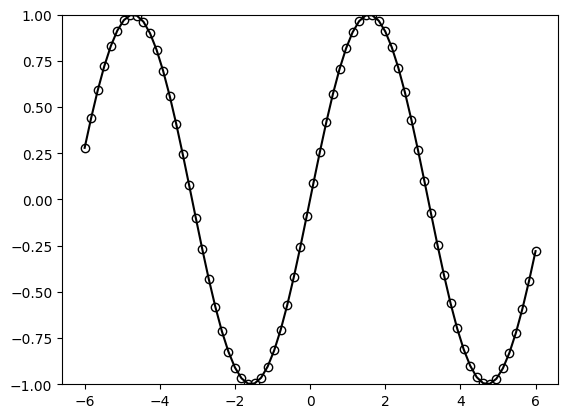

In [ ]:
rep = 2 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(rep+1, 3), requires_grad=True) # random initial weights

# Input data
x = np.linspace(-6, 6, 70, requires_grad=False)

# Using Adam Optimizer
opt = qml.AdamOptimizer(0.2)

# Batch size
batch_size = 25

# Target data
target_y = np.array([np.sin(x_) for x_ in x], requires_grad=False)


plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

In [ ]:
cst = [cost(weights, x, target_y)]  # initial cost

max_steps = 50
for step in range(max_steps):
    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.01540847056640178
Cost at step  20: 0.0012514044804207126
Cost at step  30: 0.0011537034882254317
Cost at step  40: 0.0005690792617076348
Cost at step  50: 8.943228329436512e-06


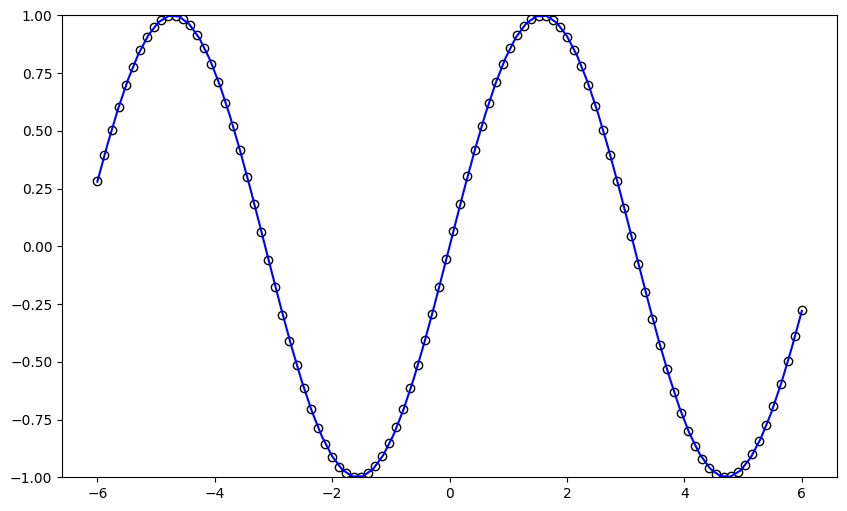

In [ ]:
# Testing it on other values to see how close they are to the sine function
x_test = np.linspace(-6, 6, 100, requires_grad=False)

predictions = [serial_quantum_model(weights, x_) for x_ in x_test]

plt.figure(figsize=(10, 6))
plt.scatter(x_test, predictions, facecolor='white', edgecolor='black')
plt.plot(x, np.sin(x), c='blue')
plt.ylim(-1,1)
plt.show();

In [ ]:
print('sqaure loss', square_loss(np.sin(x_test), predictions))

sqaure loss 8.934756332870719e-06


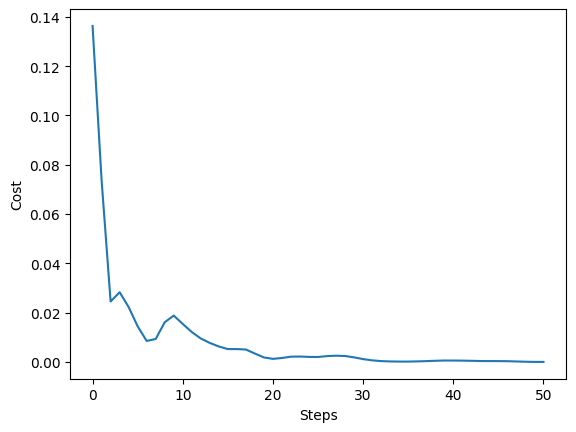

In [ ]:
# Plotting the cost function
plt.plot(cst)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Comparing different optimizers and LR

In [ ]:
def compare():
  import time
  lrs = [0.1, 0.25, 0.5]
  optimizers = [qml.AdamOptimizer, qml.RMSPropOptimizer, qml.MomentumOptimizer]
  cost_history = []
  time_history = []
  batch_size = 25
  max_steps = 50
  rep = 1 # number of times the encoding gets repeated (here equal to the number of layers)
  weights = 2 * np.pi * np.random.random(size=(rep+1, 3), requires_grad=True) # random initial weights
  for lr in lrs:
    for optimizer in optimizers:
      opt = optimizer(lr)
      cst = [cost(weights, x, target_y)]
      t0 = time.time()
      for step in range(max_steps):
          # Select batch of data
          batch_index = np.random.randint(0, len(x), (batch_size,))
          x_batch = x[batch_index]
          y_batch = target_y[batch_index]

          # Update the weights by one optimizer step
          weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

          # Save the current cost
          c = cost(weights, x, target_y)
          cst.append(c)
      t1 = time.time()
      time_history.append(t1-t0)
      cost_history.append(cst)
  return cost_history, time_history

In [ ]:
c_h, t_h = compare()

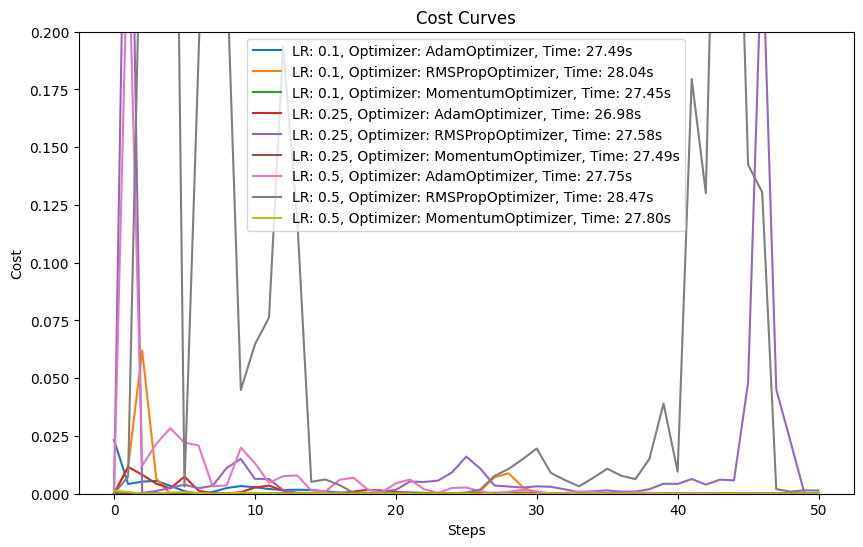

In [ ]:
def plot_cost_curves(cost_history, time_history):
    lrs = [0.1, 0.25, 0.5]
    optimizers = ['AdamOptimizer', 'RMSPropOptimizer', 'MomentumOptimizer']

    plt.figure(figsize=(10, 6))

    for i in range(len(cost_history)):
        plt.plot(cost_history[i], label=f'LR: {lrs[i//3]}, Optimizer: {optimizers[i%3]}, Time: {time_history[i]:.2f}s')

    plt.ylim(0, 0.2)
    plt.title('Cost Curves')
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

# Call the function to plot the cost curves
plot_cost_curves(c_h, t_h)


In [ ]:
import plotly.graph_objects as go

def plot_cost_curves(cost_history, time_history):
    lrs = [0.1, 0.25, 0.5]
    optimizers = ['AdamOptimizer', 'RMSPropOptimizer', 'MomentumOptimizer']

    # Create a figure
    fig = go.Figure()

    # Add traces for each combination of learning rate and optimizer
    for i in range(len(cost_history)):
        fig.add_trace(
            go.Scatter(
                y=cost_history[i],
                mode='lines',
                name=f'LR: {lrs[i//3]}, Optimizer: {optimizers[i%3]}, Time: {time_history[i]:.2f}s',
                visible=False if i != 0 else True  # Only the first trace is visible initially
            )
        )

    # Create a dropdown menu for learning rate
    lr_buttons = []
    for i, lr in enumerate(lrs):
        lr_buttons.append(
            dict(
                args=[{"visible": [j//3 == i for j in range(len(cost_history))]}],
                label=f"LR: {lr}",
                method="update"
            )
        )

    # Create a dropdown menu for optimizer
    opt_buttons = []
    for i, opt in enumerate(optimizers):
        opt_buttons.append(
            dict(
                args=[{"visible": [j%3 == i for j in range(len(cost_history))]}],
                label=f"Optimizer: {opt}",
                method="update"
            )
        )

    # Update layout to include dropdown menus
    fig.update_layout(
        updatemenus=[
            go.layout.Updatemenu(
                buttons=lr_buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
            go.layout.Updatemenu(
                buttons=opt_buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.4,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ]
    )

    # Set the title and y-axis range
    fig.update_layout(title_text="Cost Curves", yaxis_range=[0,0.2])

    # Show the figure
    fig.show()

# Call the function to plot the cost curves
plot_cost_curves(c_h, t_h)
